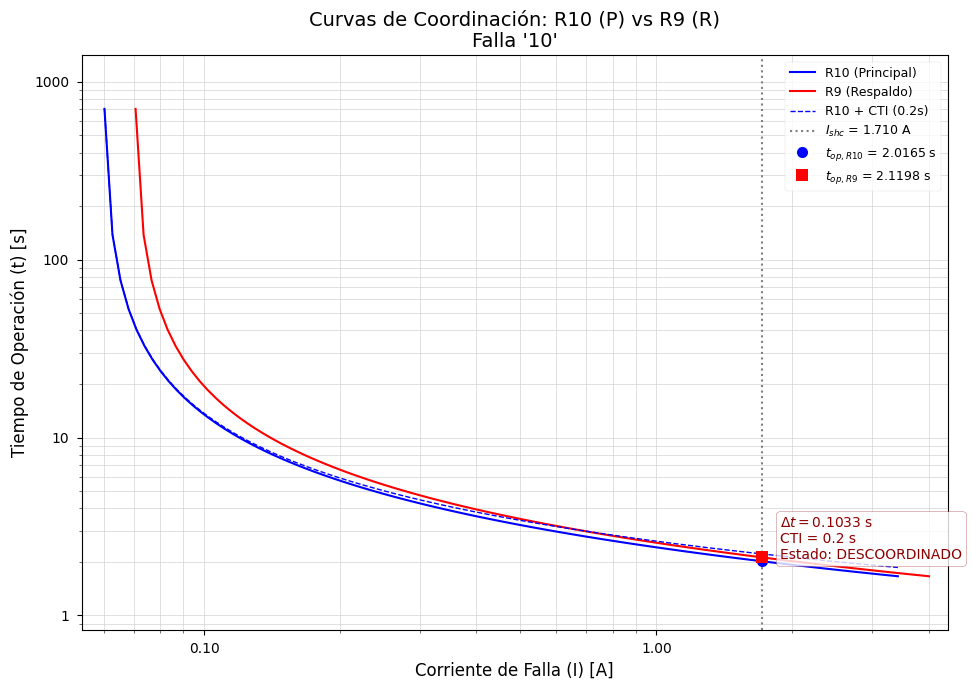

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Parámetros para las curvas
k_curve = 0.14
n_curve = 0.02
cti = 0.2

# Ruta al archivo JSON
file_path = "/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_optimization.json"

# Función para extraer parámetros
def extract_relay_parameters(data):
    relay_map = {}
    for item in data:
        for key in ['main_relay', 'backup_relay']:
            relay = item[key]
            relay_id = relay.get('relay')
            if relay_id:
                relay_map[relay_id] = {
                    'Ipi': relay.get('pick_up'),
                    'TDS': relay.get('TDS')
                }
    return relay_map

# Función para obtener los puntos de la curva
def get_curve_points(relay_id, param_map, multiples_M, k, n):
    if relay_id not in param_map:
        return None, None
    Ipi = param_map[relay_id]['Ipi']
    TDS = param_map[relay_id]['TDS']
    currents = Ipi * multiples_M
    times = TDS * k / (multiples_M**n - 1)
    return currents, times

# Cargar los datos
with open(file_path, 'r') as f:
    data = json.load(f)

# Filtrar por escenario
scenario_data = [item for item in data if item.get('scenario_id') == 'scenario_1']

# Extraer parámetros
relay_parameters_map = extract_relay_parameters(scenario_data)

# Parámetros para R10 / R9
main_relay_id = 'R10'
backup_relay_id = 'R9'
fault_context_id = '10'

# Buscar el registro específico
record = next((item for item in scenario_data
               if item['main_relay']['relay'] == main_relay_id and
                  item['backup_relay']['relay'] == backup_relay_id and
                  str(item['fault']) == str(fault_context_id)), None)

# Extraer datos para graficar
ishc_main = record['main_relay']['Ishc']
tmj = record['main_relay']['Time_out']
tbj = record['backup_relay']['Time_out']

main_params = relay_parameters_map[main_relay_id]
backup_params = relay_parameters_map[backup_relay_id]

# Generar valores de corriente
min_M = 1.01
max_M = max(25.0, (ishc_main / main_params['Ipi']) * 2, (ishc_main / backup_params['Ipi']) * 2)
multiples_M = np.logspace(np.log10(min_M), np.log10(max_M), 100)

main_currents, main_times = get_curve_points(main_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)
backup_currents, backup_times = get_curve_points(backup_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)
main_times_plus_cti = [t + cti for t in main_times]

# Graficar
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(main_currents, main_times, label=f"{main_relay_id} (Principal)", color='blue', linewidth=1.5)
ax.plot(backup_currents, backup_times, label=f"{backup_relay_id} (Respaldo)", color='red', linewidth=1.5)
ax.plot(main_currents, main_times_plus_cti, label=f"{main_relay_id} + CTI ({cti}s)", color='blue', linestyle='--', linewidth=1)

ax.axvline(x=ishc_main, color='gray', linestyle=':', linewidth=1.5, label=f"$I_{{shc}}$ = {ishc_main:.3f} A")
ax.plot(ishc_main, tmj, 'o', color='blue', markersize=8, label=f"$t_{{op, {main_relay_id}}}$ = {tmj:.4f} s")
ax.plot(ishc_main, tbj, 's', color='red', markersize=8, label=f"$t_{{op, {backup_relay_id}}}$ = {tbj:.4f} s")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(left=min(main_params['Ipi'], backup_params['Ipi']) * 0.9,
            right=max(max(main_currents), max(backup_currents)) * 1.1)

ax.set_ylim(bottom=max(0.01, min(min(main_times), min(backup_times), tmj, tbj) * 0.5),
            top=max(max(main_times_plus_cti), max(backup_times), tmj, tbj) * 2.0)

delta_t_actual = tbj - tmj
coord_status = "OK" if delta_t_actual >= cti else "DESCOORDINADO"
coord_text_color = "green" if coord_status == "OK" else "darkred"

text_x_pos = ishc_main * 1.1
text_y_pos = (tmj + tbj) / 2

ax.text(text_x_pos, text_y_pos,
        f"$\Delta t = {delta_t_actual:.4f}$ s\nCTI = {cti} s\nEstado: {coord_status}",
        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec=coord_text_color),
        color=coord_text_color)

ax.set_xlabel("Corriente de Falla (I) [A]", fontsize=12)
ax.set_ylabel("Tiempo de Operación (t) [s]", fontsize=12)
ax.set_title(f"Curvas de Coordinación: {main_relay_id} (P) vs {backup_relay_id} (R)\nFalla '{fault_context_id}'", fontsize=14)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
plt.show()


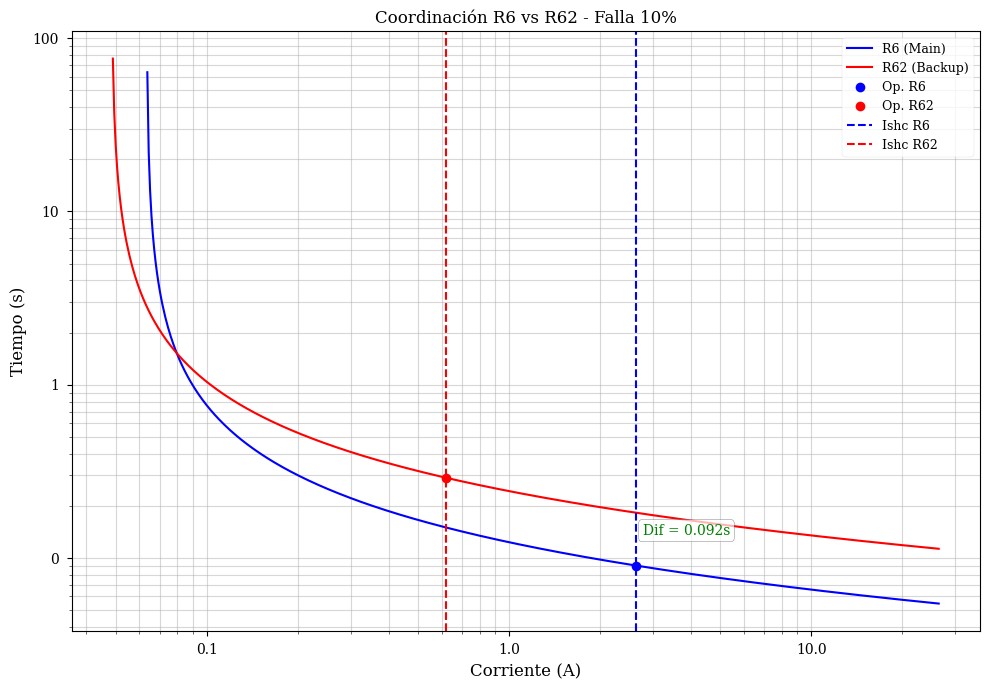

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

# Configuración general de Matplotlib
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.family'] = 'serif'

# Cálculo del tiempo de operación IEC
def calcular_tiempo_operacion_iec(I, Is, TDS, k=0.14, alpha=0.02, L=0):
    if isinstance(I, np.ndarray):
        tiempo = np.full(I.shape, np.inf, dtype=float)
        if Is <= 0:
            return tiempo
        ratio = np.where(I > 0, I / Is, -np.inf)
        calc_mask = ratio > 1
        denominador = np.where(calc_mask, np.power(ratio, alpha) - 1, np.nan)
        denominador_safe = np.where(denominador < 1e-9, 1e-9, denominador)
        tiempo[calc_mask] = TDS * ((k / denominador_safe[calc_mask]) + L)
        return tiempo
    else:
        if Is <= 0 or I <= Is:
            return np.inf
        denominador = (I / Is) ** alpha - 1
        if denominador < 1e-9:
            return np.inf
        return TDS * ((k / denominador) + L)

# Datos de ejemplo: Par R6 / R62 en falla 10%
datos_par = {
    "scenario_id": "scenario_1",
    "fault": "10",
    "main_relay": {
        "relay": "R6",
        "pick_up": 0.06334,
        "Ishc": 2.64,
        "TDS": 0.05,
        "Time_out": 0.0904,
        "line": "L6-7"
    },
    "backup_relay": {
        "relay": "R62",
        "line": "L6-26",
        "pick_up": 0.0485,
        "Ishc": 0.62,
        "TDS": 0.10844,
        "Time_out": 0.2904
    }
}

# Extraer parámetros
main = datos_par['main_relay']
backup = datos_par['backup_relay']
relay_m, relay_b = main['relay'], backup['relay']
pickup_m, pickup_b = main['pick_up'], backup['pick_up']
tds_m, tds_b = main['TDS'], backup['TDS']
ishc_m, ishc_b = main['Ishc'], backup['Ishc']
t_op_m, t_op_b = main['Time_out'], backup['Time_out']

# Corriente para la curva
corrientes = np.logspace(np.log10(min(pickup_m, pickup_b) * 1.01), np.log10(max(ishc_m, ishc_b) * 10), 600)
tiempos_m = calcular_tiempo_operacion_iec(corrientes, pickup_m, tds_m)
tiempos_b = calcular_tiempo_operacion_iec(corrientes, pickup_b, tds_b)

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(corrientes, tiempos_m, label=f'{relay_m} (Main)', color='blue', linewidth=1.5)
ax.plot(corrientes, tiempos_b, label=f'{relay_b} (Backup)', color='red', linewidth=1.5)

# Puntos de operación
ax.plot(ishc_m, t_op_m, 'bo', markersize=7, label=f'Op. {relay_m}')
ax.plot(ishc_b, t_op_b, 'ro', markersize=7, label=f'Op. {relay_b}')

# Líneas verticales de Ishc
ax.axvline(ishc_m, color='blue', linestyle='--', lw=1.5, label=f'Ishc {relay_m}')
ax.axvline(ishc_b, color='red', linestyle='--', lw=1.5, label=f'Ishc {relay_b}')

# Diferencia de tiempo en Ishc del principal
t_b_at_ishc_m = calcular_tiempo_operacion_iec(ishc_m, pickup_b, tds_b)
time_diff = t_b_at_ishc_m - t_op_m
text_x = ishc_m * 1.05
text_y = (t_op_m + t_b_at_ishc_m) / 2
ax.text(text_x, text_y, f"Dif = {time_diff:.3f}s", color='green' if time_diff > 0 else 'magenta',
        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7, ec='black'))

# Ajustes del gráfico
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Corriente (A)')
ax.set_ylabel('Tiempo (s)')
ax.set_title(f'Coordinación {relay_m} vs {relay_b} - Falla {datos_par["fault"]}%')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.5)

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
fig.tight_layout()
plt.show()


# *****

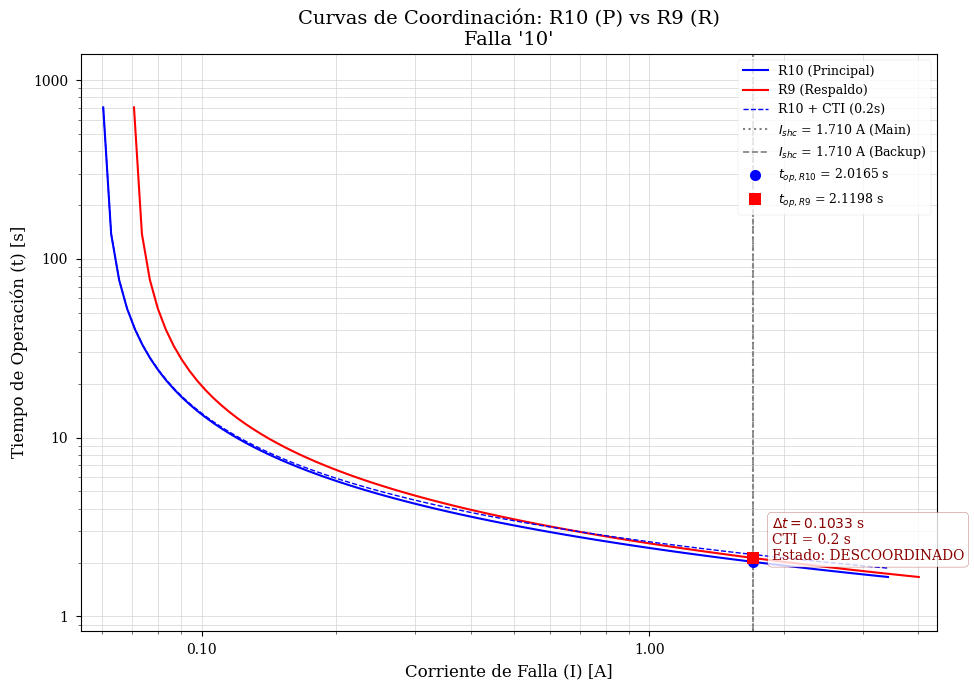

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Parámetros ---
k_curve = 0.14
n_curve = 0.02
cti = 0.2
scenario_id = 'scenario_1'
main_relay_id = 'R10'
backup_relay_id = 'R9'
fault_context_id = '10'

# --- Ruta al archivo JSON ---
file_path = "/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_optimization.json"

# --- Funciones auxiliares ---
def extract_relay_parameters(data):
    relay_map = {}
    for item in data:
        for key in ['main_relay', 'backup_relay']:
            relay = item[key]
            relay_id = relay.get('relay')
            if relay_id:
                relay_map[relay_id] = {
                    'Ipi': relay.get('pick_up'),
                    'TDS': relay.get('TDS')
                }
    return relay_map

def get_curve_points(relay_id, param_map, multiples_M, k, n):
    if relay_id not in param_map:
        return None, None
    Ipi = param_map[relay_id]['Ipi']
    TDS = param_map[relay_id]['TDS']
    currents = Ipi * multiples_M
    times = TDS * k / (multiples_M**n - 1)
    return currents, times

# --- Cargar datos JSON ---
with open(file_path, 'r') as f:
    data = json.load(f)

scenario_data = [item for item in data if item.get('scenario_id') == scenario_id]
relay_parameters_map = extract_relay_parameters(scenario_data)

# --- Buscar el par de relés específico ---
record = next((item for item in scenario_data
               if item['main_relay']['relay'] == main_relay_id and
                  item['backup_relay']['relay'] == backup_relay_id and
                  str(item['fault']) == str(fault_context_id)), None)

if not record:
    raise ValueError("No se encontró el par solicitado en el JSON.")

# --- Extraer valores clave ---
ishc_main = record['main_relay']['Ishc']
ishc_back = record['backup_relay']['Ishc']
tmj = record['main_relay']['Time_out']
tbj = record['backup_relay']['Time_out']
main_params = relay_parameters_map[main_relay_id]
backup_params = relay_parameters_map[backup_relay_id]

# --- Curvas de operación ---
min_M = 1.01
max_M = max(25.0, (ishc_main / main_params['Ipi']) * 2, (ishc_main / backup_params['Ipi']) * 2)
multiples_M = np.logspace(np.log10(min_M), np.log10(max_M), 100)

main_currents, main_times = get_curve_points(main_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)
backup_currents, backup_times = get_curve_points(backup_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)
main_times_plus_cti = [t + cti for t in main_times]

# --- Crear gráfica ---
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(main_currents, main_times, label=f"{main_relay_id} (Principal)", color='blue', linewidth=1.5)
ax.plot(backup_currents, backup_times, label=f"{backup_relay_id} (Respaldo)", color='red', linewidth=1.5)
ax.plot(main_currents, main_times_plus_cti, label=f"{main_relay_id} + CTI ({cti}s)", color='blue', linestyle='--', linewidth=1)

# Líneas verticales de Ishc
ax.axvline(x=ishc_main, color='gray', linestyle=':', linewidth=1.5, label=f"$I_{{shc}}$ = {ishc_main:.3f} A (Main)")
ax.axvline(x=ishc_back, color='gray', linestyle='--', linewidth=1.2, label=f"$I_{{shc}}$ = {ishc_back:.3f} A (Backup)")

# Puntos de operación reales
ax.plot(ishc_main, tmj, 'o', color='blue', markersize=8, label=f"$t_{{op, {main_relay_id}}}$ = {tmj:.4f} s")
ax.plot(ishc_main, tbj, 's', color='red', markersize=8, label=f"$t_{{op, {backup_relay_id}}}$ = {tbj:.4f} s")

# Escalas logarítmicas
ax.set_xscale('log')
ax.set_yscale('log')

# Límites de los ejes
ax.set_xlim(left=min(main_params['Ipi'], backup_params['Ipi']) * 0.9,
            right=max(max(main_currents), max(backup_currents)) * 1.1)
ax.set_ylim(bottom=max(0.01, min(min(main_times), min(backup_times), tmj, tbj) * 0.5),
            top=max(max(main_times_plus_cti), max(backup_times), tmj, tbj) * 2.0)

# Estado de coordinación
delta_t_actual = tbj - tmj
coord_status = "OK" if delta_t_actual >= cti else "DESCOORDINADO"
coord_text_color = "green" if coord_status == "OK" else "darkred"

text_x_pos = ishc_main * 1.1
text_y_pos = (tmj + tbj) / 2

ax.text(text_x_pos, text_y_pos,
        f"$\Delta t = {delta_t_actual:.4f}$ s\nCTI = {cti} s\nEstado: {coord_status}",
        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec=coord_text_color),
        color=coord_text_color)

# Etiquetas y leyenda
ax.set_xlabel("Corriente de Falla (I) [A]", fontsize=12)
ax.set_ylabel("Tiempo de Operación (t) [s]", fontsize=12)
ax.set_title(f"Curvas de Coordinación: {main_relay_id} (P) vs {backup_relay_id} (R)\nFalla '{fault_context_id}'", fontsize=14)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
plt.show()


In [1]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Parámetros de entrada
file_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json'
scenario_key = 'scenario_1'
cti = 0.2  # Coordination Time Interval

# --- Función de análisis de coordinación (igual que la tuya) ---
def analyze_relay_coordination(pairs_data, cti_value):
    miscoordinated = []
    all_results = []
    total_mt = 0.0
    count = 0

    for record in pairs_data:
        m = record.get('main_relay', {})
        b = record.get('backup_relay', {})
        if 'Time_out' not in m or 'Time_out' not in b:
            continue
        tm = m['Time_out']; tb = b['Time_out']
        if not isinstance(tm, (int,float)) or not isinstance(tb, (int,float)):
            continue
        count += 1
        delta_t = tb - tm - cti_value
        mt = (delta_t - abs(delta_t)) / 2.0
        total_mt += mt
        res = {**record, 'delta_t': delta_t, 'MT': mt}
        all_results.append(res)
        if mt < 0:
            miscoordinated.append(res)

    return total_mt, miscoordinated, all_results

# --- Funciones IEC y graficado ---
def calcular_tiempo_operacion_iec(I, Is, TDS, k=0.14, alpha=0.02, L=0):
    if isinstance(I, np.ndarray):
        tiempo = np.full(I.shape, np.inf)
        if Is <= 0: return tiempo
        ratio = np.where(I>0, I/Is, -np.inf)
        mask = ratio > 1
        denom = np.power(ratio[mask], alpha) - 1
        denom = np.where(denom<1e-9, 1e-9, denom)
        tiempo[mask] = TDS * ((k/denom) + L)
        return tiempo
    else:
        if Is<=0 or I<=Is: return np.inf
        denom = I/Is**alpha - 1
        if denom<1e-9: return np.inf
        return TDS * ((k/denom) + L)

def graficar_tcc_con_diferencia(par, cti_value, out_folder='./'):
    m = par['main_relay']; b = par['backup_relay']
    Pm, Tm, Ishm, tom = m['pick_up'], m['TDS'], m['Ishc'], m['Time_out']
    Pb, Tb, Ishb, tob = b['pick_up'], b['TDS'], b['Ishc'], b['Time_out']
    # rangos de corriente
    Imin = min(Pm, Pb)*1.01
    Imax = max(Ishm, Ishb, Pm, Pb)*10
    I = np.logspace(np.log10(Imin), np.log10(Imax), 600)
    t_m = calcular_tiempo_operacion_iec(I, Pm, Tm)
    t_b = calcular_tiempo_operacion_iec(I, Pb, Tb)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(I, t_m, label=f'{m["relay"]} (Main)', lw=1.5)
    ax.plot(I, t_b, label=f'{b["relay"]} (Backup)', lw=1.5)
    ax.plot(Ishm, tom, 'o', label=f'Op. {m["relay"]}')
    ax.plot(Ishb, tob, 'o', label=f'Op. {b["relay"]}')
    # diferencia en Ishm
    tb_at_ishm = calcular_tiempo_operacion_iec(Ishm, Pb, Tb)
    diff = tb_at_ishm - tom
    ax.text(Ishm*1.05, (tom+tb_at_ishm)/2,
            f'Dif={diff:.3f}s', va='center', ha='left',
            bbox=dict(fc='white', alpha=0.7))
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Corriente (A)'); ax.set_ylabel('Tiempo (s)')
    ax.set_title(f'{m["relay"]} vs {b["relay"]} – Falla {par.get("fault","N/A")}%')
    ax.legend(); ax.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    fname = f'{out_folder}TCC_{m["relay"]}_{b["relay"]}.png'
    fig.savefig(fname, dpi=300); plt.close(fig)
    print(f'Guardado: {fname}')

# --- Main ---
if __name__ == '__main__':
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # extraer lista de pares para el escenario
    if isinstance(data, dict) and scenario_key in data:
        pares = data[scenario_key]
    elif isinstance(data, list):
        pares = [r for r in data if r.get('scenario_id')==scenario_key]
    else:
        pares = []

    tmt, mis, allp = analyze_relay_coordination(pares, cti)
    print(f'TMT total en {scenario_key}: {tmt:.4f}s, pares descoordinados: {len(mis)}')

    # generar curva para cada par
    for par in allp:
        graficar_tcc_con_diferencia(par, cti)


TMT total en scenario_1: -15.8543s, pares descoordinados: 88
Guardado: ./TCC_R38_R39.png
Guardado: ./TCC_R38_R55.png
Guardado: ./TCC_R10_R9.png
Guardado: ./TCC_R47_R48.png
Guardado: ./TCC_R11_R10.png
Guardado: ./TCC_R48_R49.png
Guardado: ./TCC_R48_R72.png
Guardado: ./TCC_R12_R11.png
Guardado: ./TCC_R12_R72.png
Guardado: ./TCC_R49_R50.png
Guardado: ./TCC_R13_R12.png
Guardado: ./TCC_R50_R51.png
Guardado: ./TCC_R14_R13.png
Guardado: ./TCC_R51_R52.png
Guardado: ./TCC_R51_R34.png
Guardado: ./TCC_R15_R14.png


posx and posy should be finite values


Guardado: ./TCC_R15_R34.png
Guardado: ./TCC_R52_R53.png


posx and posy should be finite values


Guardado: ./TCC_R16_R15.png
Guardado: ./TCC_R53_R54.png
Guardado: ./TCC_R17_R16.png


posx and posy should be finite values


Guardado: ./TCC_R54_R73.png
Guardado: ./TCC_R36_R17.png
Guardado: ./TCC_R73_R32.png
Guardado: ./TCC_R19_R18.png
Guardado: ./TCC_R56_R57.png
Guardado: ./TCC_R18_R1.png


posx and posy should be finite values


Guardado: ./TCC_R18_R39.png
Guardado: ./TCC_R55_R56.png
Guardado: ./TCC_R2_R1.png
Guardado: ./TCC_R2_R55.png
Guardado: ./TCC_R39_R40.png
Guardado: ./TCC_R39_R59.png
Guardado: ./TCC_R20_R19.png
Guardado: ./TCC_R57_R58.png
Guardado: ./TCC_R57_R33.png
Guardado: ./TCC_R21_R20.png


posx and posy should be finite values


Guardado: ./TCC_R21_R33.png
Guardado: ./TCC_R58_R35.png
Guardado: ./TCC_R33_R7.png
Guardado: ./TCC_R33_R45.png
Guardado: ./TCC_R70_R58.png
Guardado: ./TCC_R70_R20.png
Guardado: ./TCC_R72_R21.png
Guardado: ./TCC_R35_R11.png
Guardado: ./TCC_R35_R49.png


posx and posy should be finite values


Guardado: ./TCC_R23_R22.png
Guardado: ./TCC_R60_R61.png
Guardado: ./TCC_R24_R23.png
Guardado: ./TCC_R61_R74.png
Guardado: ./TCC_R37_R24.png
Guardado: ./TCC_R74_R28.png
Guardado: ./TCC_R74_R66.png


posx and posy should be finite values


Guardado: ./TCC_R26_R25.png
Guardado: ./TCC_R63_R64.png
Guardado: ./TCC_R27_R26.png
Guardado: ./TCC_R64_R65.png
Guardado: ./TCC_R28_R27.png
Guardado: ./TCC_R65_R37.png
Guardado: ./TCC_R65_R66.png
Guardado: ./TCC_R29_R28.png


posx and posy should be finite values


Guardado: ./TCC_R29_R37.png
Guardado: ./TCC_R66_R67.png
Guardado: ./TCC_R22_R2.png


posx and posy should be finite values


Guardado: ./TCC_R22_R40.png
Guardado: ./TCC_R59_R60.png
Guardado: ./TCC_R3_R2.png
Guardado: ./TCC_R3_R59.png
Guardado: ./TCC_R40_R41.png


posx and posy should be finite values


Guardado: ./TCC_R30_R29.png
Guardado: ./TCC_R67_R68.png


posx and posy should be finite values


Guardado: ./TCC_R31_R30.png
Guardado: ./TCC_R68_R69.png


posx and posy should be finite values


Guardado: ./TCC_R32_R31.png
Guardado: ./TCC_R69_R36.png
Guardado: ./TCC_R4_R3.png
Guardado: ./TCC_R41_R42.png
Guardado: ./TCC_R5_R4.png
Guardado: ./TCC_R42_R43.png
Guardado: ./TCC_R42_R62.png
Guardado: ./TCC_R25_R5.png


posx and posy should be finite values


Guardado: ./TCC_R25_R43.png
Guardado: ./TCC_R62_R63.png
Guardado: ./TCC_R6_R5.png
Guardado: ./TCC_R6_R62.png
Guardado: ./TCC_R43_R44.png
Guardado: ./TCC_R7_R6.png
Guardado: ./TCC_R44_R70.png
Guardado: ./TCC_R44_R45.png
Guardado: ./TCC_R8_R7.png
Guardado: ./TCC_R8_R70.png
Guardado: ./TCC_R45_R46.png
Guardado: ./TCC_R45_R71.png
Guardado: ./TCC_R9_R8.png
Guardado: ./TCC_R9_R71.png
Guardado: ./TCC_R46_R47.png
Guardado: ./TCC_R34_R8.png
Guardado: ./TCC_R34_R46.png
Guardado: ./TCC_R71_R14.png
Guardado: ./TCC_R71_R52.png


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Parámetros de entrada
file_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json'
scenario_key = 'scenario_1'
cti = 0.2  # Coordination Time Interval

def analyze_relay_coordination(pairs_data, cti_value):
    total_mt = 0.0
    results = []
    for record in pairs_data:
        m = record.get('main_relay', {}); b = record.get('backup_relay', {})
        if 'Time_out' not in m or 'Time_out' not in b: continue
        tm, tb = m['Time_out'], b['Time_out']
        if not isinstance(tm, (int,float)) or not isinstance(tb, (int,float)): continue
        delta_t = tb - tm - cti_value
        mt = (delta_t - abs(delta_t)) / 2.0
        total_mt += mt
        rec = { **record, 'delta_t': delta_t, 'MT': mt }
        results.append(rec)
    return total_mt, results

def calcular_tiempo_operacion_iec(I, Is, TDS, k=0.14, alpha=0.02, L=0):
    I = np.array(I, dtype=float)
    tiempo = np.full(I.shape, np.inf)
    if Is <= 0: return tiempo
    ratio = I/Is
    mask = ratio > 1
    denom = np.power(ratio[mask], alpha) - 1
    denom = np.where(denom < 1e-9, 1e-9, denom)
    tiempo[mask] = TDS * ((k/denom) + L)
    return tiempo

def graficar_tcc_con_diferencia(par, cti_value, out_folder='./'):
    m = par['main_relay']; b = par['backup_relay']
    Pm, Tm, Ishm, tom = m['pick_up'], m['TDS'], m['Ishc'], m['Time_out']
    Pb, Tb, Ishb, tob = b['pick_up'], b['TDS'], b['Ishc'], b['Time_out']
    delta_t, mt = par['delta_t'], par['MT']

    # Rango de corrientes
    Imin = min(Pm, Pb)*1.01; Imax = max(Ishm, Ishb, Pm, Pb)*10
    I = np.logspace(np.log10(Imin), np.log10(Imax), 600)
    t_m = calcular_tiempo_operacion_iec(I, Pm, Tm)
    t_b = calcular_tiempo_operacion_iec(I, Pb, Tb)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(I, t_m, label=f'{m["relay"]} (Main)', lw=1.5)
    ax.plot(I, t_b, label=f'{b["relay"]} (Backup)', lw=1.5)

    # Puntos de operación con etiquetas de tiempo
    ax.plot(Ishm, tom, 'o', label=f'Op. {m["relay"]} = {tom:.3f}s')
    ax.text(Ishm*1.1, tom, f'{tom:.3f}s', va='bottom', ha='left', fontsize=9)
    ax.plot(Ishb, tob, 'o', label=f'Op. {b["relay"]} = {tob:.3f}s')
    ax.text(Ishb*1.1, tob, f'{tob:.3f}s', va='bottom', ha='left', fontsize=9)

    # Anotar MT y Δt en esquina superior derecha
    ax.text(0.95, 0.95,
            f'Δt = {delta_t:.3f}s\nMT = {mt:.3f}s',
            transform=ax.transAxes,
            va='top', ha='right',
            bbox=dict(boxstyle='round,pad=0.4', fc='white', alpha=0.7))

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)

    ax.set_xlabel('Corriente (A)')
    ax.set_ylabel('Tiempo (s)')
    ax.set_title(f'{m["relay"]} vs {b["relay"]} – Falla {par.get("fault","N/A")}%')
    ax.legend(loc='best'); ax.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()

    fname = f'{out_folder}TCC_{m["relay"]}_{b["relay"]}.png'
    fig.savefig(fname, dpi=300); plt.close(fig)
    print(f'Guardado: {fname}')

if __name__ == '__main__':
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if isinstance(data, dict) and scenario_key in data:
        pares = data[scenario_key]
    elif isinstance(data, list):
        pares = [r for r in data if r.get('scenario_id')==scenario_key]
    else:
        pares = []

    tmt, allp = analyze_relay_coordination(pares, cti)
    print(f'TMT total en {scenario_key}: {tmt:.4f}s')

    for par in allp:
        graficar_tcc_con_diferencia(par, cti)


TMT total en scenario_1: -15.8543s
Guardado: ./TCC_R38_R39.png
Guardado: ./TCC_R38_R55.png
Guardado: ./TCC_R10_R9.png
Guardado: ./TCC_R47_R48.png
Guardado: ./TCC_R11_R10.png
Guardado: ./TCC_R48_R49.png
Guardado: ./TCC_R48_R72.png
Guardado: ./TCC_R12_R11.png
Guardado: ./TCC_R12_R72.png
Guardado: ./TCC_R49_R50.png
Guardado: ./TCC_R13_R12.png
Guardado: ./TCC_R50_R51.png
Guardado: ./TCC_R14_R13.png
Guardado: ./TCC_R51_R52.png
Guardado: ./TCC_R51_R34.png
Guardado: ./TCC_R15_R14.png
Guardado: ./TCC_R15_R34.png
Guardado: ./TCC_R52_R53.png
Guardado: ./TCC_R16_R15.png
Guardado: ./TCC_R53_R54.png
Guardado: ./TCC_R17_R16.png
Guardado: ./TCC_R54_R73.png
Guardado: ./TCC_R36_R17.png
Guardado: ./TCC_R73_R32.png
Guardado: ./TCC_R19_R18.png
Guardado: ./TCC_R56_R57.png
Guardado: ./TCC_R18_R1.png
Guardado: ./TCC_R18_R39.png
Guardado: ./TCC_R55_R56.png
Guardado: ./TCC_R2_R1.png
Guardado: ./TCC_R2_R55.png
Guardado: ./TCC_R39_R40.png
Guardado: ./TCC_R39_R59.png
Guardado: ./TCC_R20_R19.png
Guardado: ./TCC_R5

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Parámetros de entrada
file_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json'
scenario_key = 'scenario_1'
cti = 0.2  # Coordination Time Interval

def analyze_relay_coordination(pairs_data, cti_value):
    total_mt = 0.0
    results = []
    for record in pairs_data:
        m = record.get('main_relay', {}); b = record.get('backup_relay', {})
        if 'Time_out' not in m or 'Time_out' not in b: continue
        tm, tb = m['Time_out'], b['Time_out']
        if not isinstance(tm, (int,float)) or not isinstance(tb, (int,float)): continue
        delta_t = tb - tm - cti_value
        mt = (delta_t - abs(delta_t)) / 2.0
        total_mt += mt
        rec = { **record, 'delta_t': delta_t, 'MT': mt }
        results.append(rec)
    return total_mt, results

def calcular_tiempo_operacion_iec(I, Is, TDS, k=0.14, alpha=0.02, L=0):
    I = np.array(I, dtype=float)
    tiempo = np.full(I.shape, np.inf)
    if Is <= 0: return tiempo
    ratio = I/Is
    mask = ratio > 1
    denom = np.power(ratio[mask], alpha) - 1
    denom = np.where(denom < 1e-9, 1e-9, denom)
    tiempo[mask] = TDS * ((k/denom) + L)
    return tiempo

def graficar_tcc_con_diferencia(par, cti_value, out_folder='./'):
    m = par['main_relay']; b = par['backup_relay']
    relay_m, relay_b = m['relay'], b['relay']
    Pm, Tm, Ishm, tom = m['pick_up'], m['TDS'], m['Ishc'], m['Time_out']
    Pb, Tb, Ishb, tob = b['pick_up'], b['TDS'], b['Ishc'], b['Time_out']
    delta_t, mt = par['delta_t'], par['MT']

    # Rango de corrientes
    Imin = min(Pm, Pb)*1.01
    Imax = max(Ishm, Ishb, Pm, Pb)*10
    I = np.logspace(np.log10(Imin), np.log10(Imax), 600)
    t_m = calcular_tiempo_operacion_iec(I, Pm, Tm)
    t_b = calcular_tiempo_operacion_iec(I, Pb, Tb)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(I, t_m, label=f'{relay_m} (Main)', lw=1.5)
    ax.plot(I, t_b, label=f'{relay_b} (Backup)', lw=1.5)

    # Puntos de operación con etiquetas de tiempo
    ax.plot(Ishm, tom, 'o', label=f'Op. {relay_m} = {tom:.3f}s')
    ax.text(Ishm*1.1, tom, f'{tom:.3f}s', va='bottom', ha='left', fontsize=9, backgroundcolor='white')
    ax.plot(Ishb, tob, 'o', label=f'Op. {relay_b} = {tob:.3f}s')
    ax.text(Ishb*1.1, tob, f'{tob:.3f}s', va='bottom', ha='left', fontsize=9, backgroundcolor='white')

    # Líneas verticales de falla y etiquetas separadas
    ymin, ymax = ax.get_ylim()
    # Main relay line
    ax.axvline(Ishm, linestyle='--', lw=1, color='blue')
    ax.text(Ishm, ymax*0.85,
            f'Ishc {relay_m} = {Ishm:.2f}A',
            rotation=90, va='top', ha='right',
            fontsize=9, backgroundcolor='white')
    # Backup relay line
    ax.axvline(Ishb, linestyle='--', lw=1, color='red')
    ax.text(Ishb, ymax*0.60,
            f'Ishc {relay_b} = {Ishb:.2f}A',
            rotation=90, va='top', ha='right',
            fontsize=9, backgroundcolor='white')

    # Anotar MT y Δt en esquina superior derecha
    ax.text(0.95, 0.95,
            f'Δt = {delta_t:.3f}s\nMT = {mt:.3f}s',
            transform=ax.transAxes,
            va='top', ha='right',
            bbox=dict(boxstyle='round,pad=0.4', fc='white', alpha=0.7))

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)

    ax.set_xlabel('Corriente (A)')
    ax.set_ylabel('Tiempo (s)')
    ax.set_title(f'{relay_m} vs {relay_b} – Falla {par.get("fault","N/A")}%')
    ax.legend(loc='best'); ax.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()

    fname = f'{out_folder}TCC_{relay_m}_{relay_b}.png'
    fig.savefig(fname, dpi=300); plt.close(fig)
    print(f'Guardado: {fname}')

if __name__ == '__main__':
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if isinstance(data, dict) and scenario_key in data:
        pares = data[scenario_key]
    elif isinstance(data, list):
        pares = [r for r in data if r.get('scenario_id') == scenario_key]
    else:
        pares = []

    tmt, allp = analyze_relay_coordination(pares, cti)
    print(f'TMT total en {scenario_key}: {tmt:.4f}s')

    for par in allp:
        graficar_tcc_con_diferencia(par, cti)


TMT total en scenario_1: -15.8543s
Guardado: ./TCC_R38_R39.png
Guardado: ./TCC_R38_R55.png
Guardado: ./TCC_R10_R9.png
Guardado: ./TCC_R47_R48.png
Guardado: ./TCC_R11_R10.png
Guardado: ./TCC_R48_R49.png
Guardado: ./TCC_R48_R72.png
Guardado: ./TCC_R12_R11.png
Guardado: ./TCC_R12_R72.png
Guardado: ./TCC_R49_R50.png
Guardado: ./TCC_R13_R12.png
Guardado: ./TCC_R50_R51.png
Guardado: ./TCC_R14_R13.png
Guardado: ./TCC_R51_R52.png
Guardado: ./TCC_R51_R34.png
Guardado: ./TCC_R15_R14.png
Guardado: ./TCC_R15_R34.png
Guardado: ./TCC_R52_R53.png
Guardado: ./TCC_R16_R15.png
Guardado: ./TCC_R53_R54.png
Guardado: ./TCC_R17_R16.png
Guardado: ./TCC_R54_R73.png
Guardado: ./TCC_R36_R17.png
Guardado: ./TCC_R73_R32.png
Guardado: ./TCC_R19_R18.png
Guardado: ./TCC_R56_R57.png
Guardado: ./TCC_R18_R1.png
Guardado: ./TCC_R18_R39.png
Guardado: ./TCC_R55_R56.png
Guardado: ./TCC_R2_R1.png
Guardado: ./TCC_R2_R55.png
Guardado: ./TCC_R39_R40.png
Guardado: ./TCC_R39_R59.png
Guardado: ./TCC_R20_R19.png
Guardado: ./TCC_R5

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Parámetros de entrada
file_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json'
scenario_key = 'scenario_1'
cti = 0.2  # Coordination Time Interval

def analyze_relay_coordination(pairs_data, cti_value):
    total_mt = 0.0
    results = []
    for record in pairs_data:
        m = record.get('main_relay', {}); b = record.get('backup_relay', {})
        if 'Time_out' not in m or 'Time_out' not in b: continue
        tm, tb = m['Time_out'], b['Time_out']
        if not isinstance(tm, (int,float)) or not isinstance(tb, (int,float)): continue
        delta_t = tb - tm - cti_value
        mt = (delta_t - abs(delta_t)) / 2.0
        total_mt += mt
        rec = { **record, 'delta_t': delta_t, 'MT': mt }
        results.append(rec)
    return total_mt, results

def calcular_tiempo_operacion_iec(I, Is, TDS, k=0.14, alpha=0.02, L=0):
    I = np.array(I, dtype=float)
    tiempo = np.full(I.shape, np.inf)
    if Is <= 0: return tiempo
    ratio = I/Is
    mask = ratio > 1
    denom = np.power(ratio[mask], alpha) - 1
    denom = np.where(denom < 1e-9, 1e-9, denom)
    tiempo[mask] = TDS * ((k/denom) + L)
    return tiempo

def graficar_tcc_con_diferencia(par, cti_value, out_folder='./'):
    m = par['main_relay']; b = par['backup_relay']
    relay_m, relay_b = m['relay'], b['relay']
    Pm, Tm, Ishm, tom = m['pick_up'], m['TDS'], m['Ishc'], m['Time_out']
    Pb, Tb, Ishb, tob = b['pick_up'], b['TDS'], b['Ishc'], b['Time_out']
    delta_t, mt = par['delta_t'], par['MT']

    # Rango de corrientes
    Imin = min(Pm, Pb)*1.01
    Imax = max(Ishm, Ishb, Pm, Pb)*10
    I = np.logspace(np.log10(Imin), np.log10(Imax), 600)
    t_m = calcular_tiempo_operacion_iec(I, Pm, Tm)
    t_b = calcular_tiempo_operacion_iec(I, Pb, Tb)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(I, t_m, label=f'{relay_m} (Main)', lw=1.5)
    ax.plot(I, t_b, label=f'{relay_b} (Backup)', lw=1.5)

    # Puntos de operación con etiquetas de tiempo
    ax.plot(Ishm, tom, 'o', label=f'Op. {relay_m} = {tom:.3f}s')
    ax.text(Ishm*1.1, tom, f'{tom:.3f}s', va='bottom', ha='left', fontsize=9, backgroundcolor='white')
    ax.plot(Ishb, tob, 'o', label=f'Op. {relay_b} = {tob:.3f}s')
    ax.text(Ishb*1.1, tob, f'{tob:.3f}s', va='bottom', ha='left', fontsize=9, backgroundcolor='white')

    # Líneas verticales de falla y etiquetas separadas
    ymin, ymax = ax.get_ylim()
    ax.axvline(Ishm, linestyle='--', lw=1, color='blue')
    ax.text(Ishm, ymax*0.85,
            f'Ishc {relay_m} = {Ishm:.2f}A',
            rotation=90, va='top', ha='right',
            fontsize=9, backgroundcolor='white')
    ax.axvline(Ishb, linestyle='--', lw=1, color='red')
    ax.text(Ishb, ymax*0.60,
            f'Ishc {relay_b} = {Ishb:.2f}A',
            rotation=90, va='top', ha='right',
            fontsize=9, backgroundcolor='white')

    # Anotar MT y Δt en esquina inferior izquierda
    ax.text(0.05, 0.05,
            f'Δt = {delta_t:.3f}s\nMT = {mt:.3f}s',
            transform=ax.transAxes,
            va='bottom', ha='left',
            bbox=dict(boxstyle='round,pad=0.4', fc='white', alpha=0.7))

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)

    ax.set_xlabel('Corriente (A)')
    ax.set_ylabel('Tiempo (s)')
    ax.set_title(f'{relay_m} vs {relay_b} – Falla {par.get("fault","N/A")}%')
    ax.legend(loc='best'); ax.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()

    fname = f'{out_folder}TCC_{relay_m}_{relay_b}.png'
    fig.savefig(fname, dpi=300); plt.close(fig)
    print(f'Guardado: {fname}')

if __name__ == '__main__':
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if isinstance(data, dict) and scenario_key in data:
        pares = data[scenario_key]
    elif isinstance(data, list):
        pares = [r for r in data if r.get('scenario_id') == scenario_key]
    else:
        pares = []

    tmt, allp = analyze_relay_coordination(pares, cti)
    print(f'TMT total en {scenario_key}: {tmt:.4f}s')

    for par in allp:
        graficar_tcc_con_diferencia(par, cti)


TMT total en scenario_1: -15.8543s
Guardado: ./TCC_R38_R39.png
Guardado: ./TCC_R38_R55.png
Guardado: ./TCC_R10_R9.png
Guardado: ./TCC_R47_R48.png
Guardado: ./TCC_R11_R10.png
Guardado: ./TCC_R48_R49.png
Guardado: ./TCC_R48_R72.png
Guardado: ./TCC_R12_R11.png
Guardado: ./TCC_R12_R72.png
Guardado: ./TCC_R49_R50.png
Guardado: ./TCC_R13_R12.png
Guardado: ./TCC_R50_R51.png
Guardado: ./TCC_R14_R13.png
Guardado: ./TCC_R51_R52.png
Guardado: ./TCC_R51_R34.png
Guardado: ./TCC_R15_R14.png
Guardado: ./TCC_R15_R34.png
Guardado: ./TCC_R52_R53.png
Guardado: ./TCC_R16_R15.png
Guardado: ./TCC_R53_R54.png
Guardado: ./TCC_R17_R16.png
Guardado: ./TCC_R54_R73.png
Guardado: ./TCC_R36_R17.png
Guardado: ./TCC_R73_R32.png
Guardado: ./TCC_R19_R18.png
Guardado: ./TCC_R56_R57.png
Guardado: ./TCC_R18_R1.png
Guardado: ./TCC_R18_R39.png
Guardado: ./TCC_R55_R56.png
Guardado: ./TCC_R2_R1.png
Guardado: ./TCC_R2_R55.png
Guardado: ./TCC_R39_R40.png
Guardado: ./TCC_R39_R59.png
Guardado: ./TCC_R20_R19.png
Guardado: ./TCC_R5